In [1]:
# Load libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.integrate

# Use Gaussian process from scikit-learn
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from sklearn.preprocessing import StandardScaler

In [2]:
################################# 
######## Define the model ######
#################################

# Return observable given parameter
def charged_hadron_multiplicity(params):
    
    norm=params['norm']
    eta_over_s_eff=params['eta_over_s_eff']
    
    result=100*norm*(1+eta_over_s_eff)                        #<====================================================
    
    return result

# Return observable given parameter
def charged_hadron_v2(params):
    
    norm=params['norm']
    eta_over_s_eff=params['eta_over_s_eff']
    
    result=0.04/(1+6*eta_over_s_eff)+0.0003*norm              #<=========================================================
    
    return result


# Dictionary of parameters
# "label" is used for plotting purposes
# "range" is the allowed range of the parameter (a simple uniform "prior")
# "truth" is the value of the parameters used for the closure test
parameter_d={
    'norm':{
        "label":"Normalization of energy deposition",
        "range":[6,12],                                     #<====================================================
        "truth":10.,                                         #<====================================================
        "nb_design_pts":15
    },
    'eta_over_s_eff':{
        "label":r"Effective $\eta/s$", 
        "range":[.01,.3],                                   #<====================================================
        "truth":0.12,                                        #<====================================================
        "nb_design_pts":15
    }
}

# Observable dictionary
obs_d={
    "multiplicity":{
        'fct':charged_hadron_multiplicity,
        'label':r'$dN_{ch}/d\eta$',
        'fake_exp_rel_uncert':0.05,                       #<====================================================
        'theoretical_relative_uncertainty':0.01           #<====================================================
    },
    "v2":{
        'fct':charged_hadron_v2,
        'label':r'$v_2\{2\}$',
        'fake_exp_rel_uncert':0.05,                       #<====================================================
        'theoretical_relative_uncertainty':0.01           #<====================================================
    },
    
}

In [3]:
#########################
#### Get the "data" #####
#########################

# Data dictionary
data_d={}

# This will be a "closure test": we use the model to generate "data"
# The Bayesian parameter estimation should be peaked around the true value of the parameters
for obs_name, info_d in obs_d.items():
    
    #
    obs_fct=info_d['fct']
    
    #
    data_d[obs_name]={}
    
    # Parameters
    param_value_list={item:tmp_d['truth'] for (item, tmp_d) in parameter_d.items() }
    
    tmp_value=obs_fct(param_value_list)
    data_d[obs_name]['mean']=tmp_value
    
    fake_exp_rel_uncert=info_d['fake_exp_rel_uncert']
        
    data_d[obs_name]['uncert']=fake_exp_rel_uncert*tmp_value

print(data_d)
#print(list(parameter_d.keys()))

{'multiplicity': {'mean': 1120.0, 'uncert': 56.0}, 'v2': {'mean': 0.02625581395348837, 'uncert': 0.0013127906976744185}}


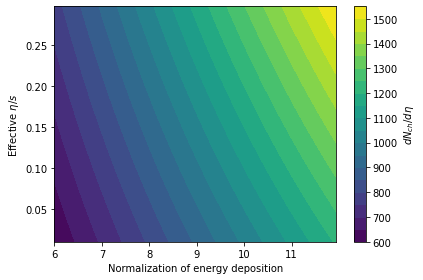

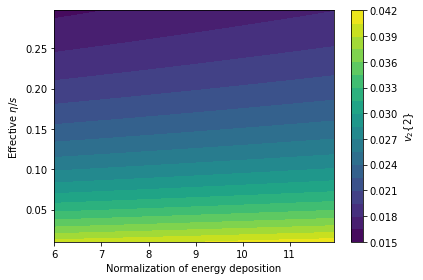

In [4]:
#########################
#### Plot the "data" #####
#########################

for obs_name, info_d in obs_d.items():

    # Function that returns the value of an observable
    obs_fct=info_d['fct']
    
    # Label for the observable
    obs_label=info_d['label']
    
    # Data
    tmp_data_d=data_d[obs_name]
    data_mean=tmp_data_d['mean']
    data_uncert=tmp_data_d['uncert']
    
    # Info about parameters
    param_name_list=list(parameter_d.keys())
    
    x_param_name=param_name_list[0]
    xmin, xmax = parameter_d[x_param_name]['range']
    x_label=parameter_d[x_param_name]['label']

    y_param_name=param_name_list[1]
    ymin, ymax = parameter_d[y_param_name]['range']
    y_label=parameter_d[y_param_name]['label']
    
    
    # Plot what the observable looks like over the parameter prior
    plt.figure()
    plt.xscale('linear')
    plt.yscale('linear')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    # Compute the posterior for a range of values of the parameter "x"
    x_range=np.arange(xmin, xmax, (xmax-xmin)/100.)
    y_range=np.arange(ymin, ymax, (ymax-ymin)/100.)

    x_mesh, y_mesh =  np.meshgrid(x_range, y_range, sparse=False, indexing='ij')

    z_list = [ obs_fct({x_param_name:x_val, y_param_name:y_val}) for (x_val,y_val) in zip(x_mesh,y_mesh) ]

    # Plot the posterior
    cs = plt.contourf(x_mesh, y_mesh, z_list, 20)

    cbar = plt.colorbar(cs,label=obs_label) 

    # Plot the "data"
    # plt.contour(x_mesh, y_mesh, z_list, levels=[data_mean],colors='r')
    # plt.contourf(x_mesh, y_mesh, z_list, levels=[data_mean-data_uncert,data_mean+data_uncert],colors='r',alpha=.4)

    plt.tight_layout()
    plt.show()

In [5]:
########################
# Get the calculations #
########################

calc_d={}

for obs_name, info_d in obs_d.items():

    # Function that returns the value of an observable
    obs_fct=info_d['fct']
        
    # Info about parameters
    param_name_list=list(parameter_d.keys())
        
    param1_name=param_name_list[0]
    param1_min, param1_max = parameter_d[param1_name]['range']
    param1_nb_design_pts=parameter_d[param1_name]["nb_design_pts"]

    param2_name=param_name_list[1]
    param2_min, param2_max = parameter_d[param2_name]['range']
    param2_nb_design_pts=parameter_d[param2_name]["nb_design_pts"]

    # For simplicity, we sample the emulator uniformly
    param1_design_list=np.linspace(param1_min,param1_max,num=param1_nb_design_pts)
    param2_design_list=np.linspace(param2_min,param2_max,num=param2_nb_design_pts)

    param1_mesh, param2_mesh =  np.meshgrid(param1_design_list, param2_design_list, sparse=False, indexing='ij')
    
    calculation_mean_list = np.array([ obs_fct({param1_name:param1_val, param2_name:param2_val}) for (param1_val,param2_val) in zip(param1_mesh,param2_mesh) ])

    relative_uncertainty=info_d['theoretical_relative_uncertainty']
    
    calculation_uncert_list=calculation_mean_list*relative_uncertainty #np.multiply(np.full_like(calculation_mean_list,np.mean(calculation_mean_list)),relative_uncertainty)
    
    calculation_mean_plus_noise=calculation_mean_list+[ np.random.normal(0,uncert) for uncert in calculation_uncert_list]
    
    calc_d[obs_name]={'param1_mesh':param1_mesh,'param2_mesh':param2_mesh,'param1_list':param1_design_list,'param2_list':param2_design_list,'mean':calculation_mean_list, 'mean_plus_noise':calculation_mean_plus_noise,'uncert':calculation_uncert_list}

Information on emulator for observable $dN_{ch}/d\eta$
RBF:  316**2 * RBF(length_scale=[5.11, 0.777])
White:  85.2**2 * WhiteKernel(noise_level=0.0142)
[ 6.          6.42857143  6.85714286  7.28571429  7.71428571  8.14285714
  8.57142857  9.          9.42857143  9.85714286 10.28571429 10.71428571
 11.14285714 11.57142857 12.        ]


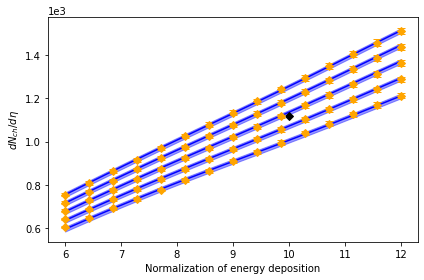

Information on emulator for observable $v_2\{2\}$
RBF:  0.0261**2 * RBF(length_scale=[18, 0.301])
White:  0.00316**2 * WhiteKernel(noise_level=0.0025)
[ 6.          6.42857143  6.85714286  7.28571429  7.71428571  8.14285714
  8.57142857  9.          9.42857143  9.85714286 10.28571429 10.71428571
 11.14285714 11.57142857 12.        ]


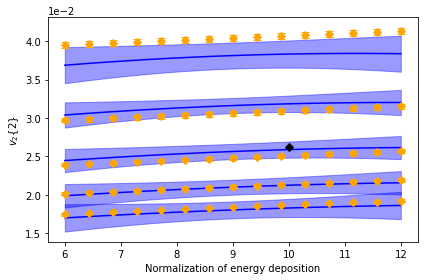

In [6]:
#####################################
# Make emulator for each observable #
#####################################

emul_d={}

for obs_name, info_d in obs_d.items():
    
    # Label for the observable
    obs_label=info_d['label']
    
    # Function that returns the value of an observable (just to get the truth)
    obs_fct=info_d['fct']
    
    param1_name=param_name_list[0]
    param1_min, param1_max = parameter_d[param1_name]['range']
    param1_label=parameter_d[param1_name]['label']
    param1_nb_design_pts=parameter_d[param1_name]["nb_design_pts"]
    param1_truth=parameter_d[param1_name]['truth']

    param2_name=param_name_list[1]
    param2_min, param2_max = parameter_d[param2_name]['range']
    param2_label=parameter_d[param2_name]['label']
    param2_nb_design_pts=parameter_d[param2_name]["nb_design_pts"]
    param2_truth=parameter_d[param2_name]['truth']
    
    param1_paramspace_length = param1_max-param1_min
    param2_paramspace_length = param2_max-param2_min

    # Kernels
    k0 = 1. * kernels.RBF(
        length_scale=(param1_paramspace_length/2.,param2_paramspace_length/2.),
        length_scale_bounds=(
            (param1_paramspace_length/param1_nb_design_pts, 3.*param1_paramspace_length),
            (param2_paramspace_length/param2_nb_design_pts, 3.*param2_paramspace_length)
            )
    )
    
    relative_uncertainty=info_d['theoretical_relative_uncertainty']
    k2 = 1. * kernels.WhiteKernel(
        noise_level=relative_uncertainty,
        #noise_level_bounds='fixed'
        noise_level_bounds=(relative_uncertainty/4.,4*relative_uncertainty)
    )

    kernel = (k0+k2)

    nrestarts=10

    emulator_design_pts_value=np.transpose([np.ravel(calc_d[obs_name]['param1_mesh']), np.ravel(calc_d[obs_name]['param2_mesh'])])
    #emulator_obs_mean_value=np.ravel(calc_d[obs_name]['mean'])
    emulator_obs_mean_value=np.ravel(calc_d[obs_name]['mean_plus_noise'])
    
    #emulator_y_input_transform=emulator_y_input
    
    #print(emulator_design_pts_value)
    #print(emulator_obs_mean_value)


    # Fit a GP (optimize the kernel hyperparameters) to each PC.
    gaussian_process=GPR(
        kernel=kernel,
        alpha=0.0001,
        n_restarts_optimizer=nrestarts,
        copy_X_train=True
        ).fit(emulator_design_pts_value,emulator_obs_mean_value)

    # https://github.com/keweiyao/JETSCAPE2020-TRENTO-BAYES/blob/master/trento-bayes.ipynb
    print('Information on emulator for observable '+obs_label)
    print('RBF: ', gaussian_process.kernel_.get_params()['k1'])
    print('White: ', gaussian_process.kernel_.get_params()['k2'])

    print(calc_d[obs_name]['param1_list'])
    emul_d[obs_name]={
        'gpr':gaussian_process
    #    'mean':scipy.interpolate.interp2d(calc_d[obs_name]['x_list'], calc_d[obs_name]['y_list'], np.transpose(calc_d[obs_name]['mean']), kind='linear', copy=True, bounds_error=False, fill_value=None),
    #    'uncert':scipy.interpolate.interp2d(calc_d[obs_name]['x_list'], calc_d[obs_name]['y_list'], np.transpose(calc_d[obs_name]['uncert']), kind='linear', copy=True, bounds_error=False, fill_value=None)
    }
    
    
    #####################
    # Plot the emulator #
    #####################

    # observable vs value of one parameter (with the other parameter fixed)
    plt.figure()
    plt.xscale('linear')
    plt.yscale('linear')
    plt.xlabel(param1_label)
    plt.ylabel(obs_label)

    len_y=len(calc_d[obs_name]['param2_list'])
    step_y=np.max([int(len_y/5),1])
     
    for iy in np.arange(0,len_y,step_y):
        
        y=calc_d[obs_name]['param2_list'][iy]
        y_label=param2_label
        
        # Compute the posterior for a range of values of the parameter "x"
        x_range=np.linspace(param1_min,param1_max, 50)
        y_range=np.full_like(x_range,y)
        
        param_value_array=np.transpose([x_range,y_range])
        
        z_list,z_list_uncert = gaussian_process.predict(param_value_array, return_std=True)
        #print('param_value_array',param_value_array)
        #print('z_list',z_list)

        #print('all=',calc_d[obs_name]['mean'])
        #print('shape=',np.array(calc_d[obs_name]['mean']).shape)
        #print('w iy',np.array(calc_d[obs_name]['mean'])[:,iy])
        
        # Plot design points
        plt.errorbar(calc_d[obs_name]['param1_list'], np.array(calc_d[obs_name]['mean'])[:,iy], yerr=np.array(calc_d[obs_name]['uncert'])[:,iy], fmt='D', color='orange',capsize=4, label=y_label+"="+str(y))

        #print(calc_d[obs_name]['x_list'],calc_d[obs_name]['mean'][iy],calc_d[obs_name]['uncert'][iy])
        
        # Plot interpolator
        plt.plot(x_range, z_list, color='blue')
        plt.fill_between(x_range, z_list-z_list_uncert, z_list+z_list_uncert, color='blue',alpha=.4)

    # Plot the truth
    plt.plot(param1_truth, obs_fct({param1_name:param1_truth, param2_name:param2_truth}), "D", color='black')    
        
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))


    plt.tight_layout()
    plt.show()


In [10]:
#########################
# Compute the posterior #
#########################

# We assume uniform priors for this example
# Here 'x' is the only model parameter
def prior(params):
    
    return 1


# Under the approximations that we're using, the posterior is
# exp(-1/2*\sum_{observables, pT} (model(observable,pT)-data(observable,pT))^2/(model_err(observable,pT)^2+exp_err(observable,pT)^2)

# Here 'x' is the only model parameter
def likelihood(params, data):

    res=0.0

    norm=1.
    
    # Sum over observables
    for obs_name, info_d in obs_d.items():
        
        # Function that returns the value of an observable
        obs_fct=info_d['fct']
        
        emulator=emul_d[obs_name]['gpr']
        
        #emulator_calc=emul_d[obs_name]['mean']
        #emulator_uncert=emul_d[obs_name]['uncert']
        
        data_mean=data[obs_name]['mean']
        data_uncert=data[obs_name]['uncert']
        
        # Vectorize the emulators
        #emulator_calc_vec = np.vectorize(emulator_calc)
        #emulator_uncert_vec = np.vectorize(emulator_uncert)

        # Info about parameters
        param_name_list=list(parameter_d.keys())
        param1_name=param_name_list[0]
        param1_val=params[x_param_name]
    
        param2_name=param_name_list[1]
        param2_val=params[y_param_name]
        
        tmp_data_mean,tmp_data_uncert = data_mean, data_uncert
        
        tmp_model_mean,tmp_model_uncert = emulator.predict(np.atleast_2d(np.transpose([param1_val,param2_val])), return_std=True)

        cov=(tmp_model_uncert*tmp_model_uncert+tmp_data_uncert*tmp_data_uncert)

        res+=np.power(tmp_model_mean-tmp_data_mean,2)/cov
        
        norm*=1/np.sqrt(cov)

    res*=-0.5
  
    return norm*np.exp(res)


#
def posterior(params,data):
    
    return prior(params)*likelihood(params,data)


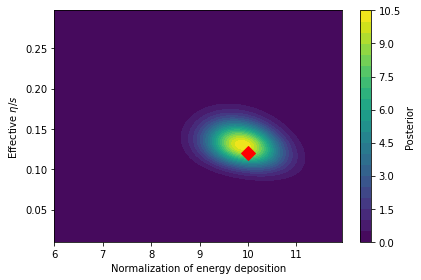

In [11]:
##################
# Plot posterior #
##################


# Info about parameters
param_name_list=list(parameter_d.keys())

param1_name=param_name_list[0]
param1_min, param1_max = parameter_d[param1_name]['range']
param1_label=parameter_d[param1_name]['label']
param1_truth=parameter_d[param1_name]['truth']

param2_name=param_name_list[1]
param2_min, param2_max = parameter_d[param2_name]['range']
param2_label=parameter_d[param2_name]['label']
param2_truth=parameter_d[param2_name]['truth']


plt.figure()
plt.xscale('linear')
plt.yscale('linear')
plt.xlabel(param1_label)
plt.ylabel(param2_label)

# Compute the posterior for a range of values of the parameter "x"
param1_range=np.arange(param1_min, param1_max, (param1_max-param1_min)/100.)
param2_range=np.arange(param2_min, param2_max, (param2_max-param2_min)/100.)

param1_mesh, param2_mesh =  np.meshgrid(param1_range, param2_range, sparse=False, indexing='ij')

posterior_array = [ posterior({param1_name:param1_val, param2_name:param2_val},data_d) for (param1_val,param2_val) in zip(param1_mesh,param2_mesh) ]

# Plot the posterior
cs = plt.contourf(param1_mesh, param2_mesh, posterior_array, 20)

cbar = plt.colorbar(cs,label="Posterior") 

plt.plot([param1_truth], [param2_truth],"D",color='red',ms=10)

plt.tight_layout()
plt.show()

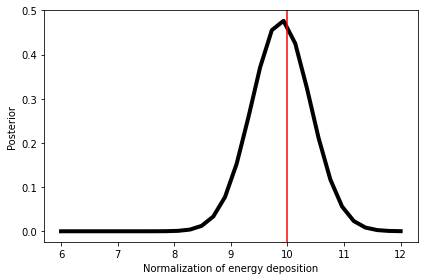

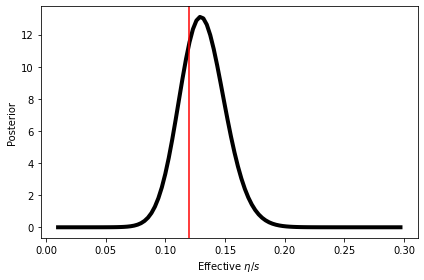

In [12]:
###############################
# Plotting marginal posterior #
###############################

# Posterior vs param_1
plt.figure()
plt.xscale('linear')
plt.yscale('linear')
#plt.xlim(0,2)
#plt.ylim(1e-5,1e2)
plt.xlabel(param1_label)
plt.ylabel(r'Posterior')

# The marginal posterior for a parameter is obtained by integrating over a subset of other model parameters

# Compute the posterior for a range of values of the parameter "param_1"
param1_range=np.linspace(param1_min, param1_max, 30)

posterior_list = [ scipy.integrate.quad(lambda param2_val: posterior({param1_name:param1_val, param2_name:param2_val},data_d),param2_min,param2_max)[0] for param1_val in param1_range ]

plt.plot(param1_range, posterior_list, "-", color='black', lw=4)

plt.axvline(x=param1_truth,color='red')

plt.tight_layout()
plt.show()


# Posterior vs param_2
plt.figure()
plt.xscale('linear')
plt.yscale('linear')
plt.xlabel(param2_label)
plt.ylabel(r'Posterior')

# The marginal posterior for a parameter is obtained by integrating over a subset of other model parameters

# Compute the posterior for a range of values of the parameter "param_2"
param1_range=np.linspace(param2_min, param1_max, 30)

posterior_list = [ scipy.integrate.quad(lambda param1_val: posterior({param1_name:param1_val, param2_name:param2_val},data_d),param1_min,param1_max)[0] for param2_val in param2_range ]

plt.plot(param2_range, posterior_list, "-", color='black', lw=4)

plt.axvline(x=param2_truth,color='red')

plt.tight_layout()
plt.show()
